<a href="https://colab.research.google.com/github/victoreeckh/Model_free_HCA_1_feeder_v1/blob/main/PFE_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Power Flow Engine model

In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import time
import os
import json
import math

In [ ]:
!pip install dss_python
!pip install dss

In [3]:
import dss
dss_via_python = dss.DSS
print(dss_via_python) # check object type

### Data acquisition

In [4]:
#import files from FNAData/Network
from google.colab import files
uploaded = files.upload()

Saving 65019_74478_Mod_branches.json to 65019_74478_Mod_branches.json
Saving 65019_74478_Mod_buses.json to 65019_74478_Mod_buses.json
Saving 65019_74478_mod_configuration.json to 65019_74478_mod_configuration.json
Saving 65019_74478_Mod_devices.json to 65019_74478_Mod_devices.json


In [ ]:
#import files from FNAData/ScenariosRobustSolution
from google.colab import files
uploaded = files.upload()

In [6]:
with open('/content/65019_74478_Mod_branches.json', 'r') as file:
    branches = json.load(file)
with open('/content/65019_74478_Mod_buses.json', 'r') as file:
    buses = json.load(file)
with open('/content/65019_74478_Mod_devices.json', 'r') as file:
    devices = json.load(file)
    LVcustomers = devices['LVcustomers']
    solarGens = devices['solarGens']
with open('/content/65019_74478_mod_configuration.json', 'r') as file:
    configuration = json.load(file)
print(branches)
print(buses)
print(devices)
print(configuration)

[{'branchId': 0, 'cableLength': 17.0, 'cableType': 'BT - RV 0,6/1 KV 3(1*150 KAL) + 1*95 KAL', 'downBusId': 1, 'type': 'Cable', 'upBusId': 0}, {'branchId': 1, 'cableLength': 23.0, 'cableType': 'BT - RV 0,6/1 KV 3(1*150 KAL) + 1*95 KAL', 'downBusId': 2, 'type': 'Cable', 'upBusId': 1}, {'branchId': 2, 'cableLength': 5.0, 'cableType': 'BT - RV 0,6/1 KV 4*95 KAL', 'downBusId': 3, 'type': 'Cable', 'upBusId': 2}, {'branchId': 3, 'cableLength': 10, 'cableType': 'BT - RV 0,6/1 KV 4*95 KAL', 'downBusId': 4, 'type': 'Cable', 'upBusId': 3}, {'branchId': 4, 'cableLength': 1.0, 'cableType': 'BT - RV 0,6/1 KV 3(1*150 KAL) + 1*95 KAL', 'downBusId': 5, 'type': 'Cable', 'upBusId': 2}, {'branchId': 5, 'cableLength': 25.0, 'cableType': 'BT - RZ 0,6/1 KV 3*150 AL/95 ALM', 'downBusId': 6, 'type': 'Cable', 'upBusId': 5}, {'branchId': 6, 'cableLength': 20.0, 'cableType': 'BT - RZ 0,6/1 KV 3*150 AL/95 ALM', 'downBusId': 7, 'type': 'Cable', 'upBusId': 6}, {'branchId': 7, 'cableLength': 2.0, 'cableType': 'BT - 

In [7]:
print(len(branches))
print(len(buses))
print(len(devices))
print(len(LVcustomers))
print(len(solarGens))

75
76
2
52
0


In [8]:
# House0 = pd.read_csv('/content/House0.csv', header=None)
# print(House0.shape)

Load_time_series = np.zeros((len(LVcustomers),1000,24))
for i in range(len(LVcustomers)):
  dir = f'/content/House{1}.csv'
  New_house = pd.read_csv(dir, header=None)
  Load_time_series[i, :, :] = New_house.values.T
print(Load_time_series.shape)

(52, 1000, 24)


In [9]:
impedance_dict = {
    "BT - Desconocido BT": [0.21, 0.075],
    "BT - MANGUERA": [0.3586, 0.089],
    "BT - RV 0,6/1 KV 2*16 KAL": [2.14, 0.09],
    "BT - RV 0,6/1 KV 2*25 KAL": [1.34, 0.097],
    "BT - RV 0,6/1 KV 3(1*150 KAL) + 1*95 KAL": [0.2309, 0.085],
    "BT - RV 0,6/1 KV 3(1*240 KAL) + 1*150 KAL": [0.1602, 0.079],
    "BT - RV 0,6/1 KV 3(1*240 KAL) + 1*95 KAL": [0.1602, 0.079],
    "BT - RV 0,6/1 KV 4*25 KAL": [1.34, 0.097],
    "BT - RV 0,6/1 KV 4*50 KAL": [0.71849, 0.093],
    "BT - RV 0,6/1 KV 4*95 KAL": [0.3586, 0.089],
    "BT - RX 0,6/1 KV 2*16 Cu": [1.23, 0.08],
    "BT - RX 0,6/1 KV 2*2 Cu": [9.9, 0.075],
    "BT - RX 0,6/1 KV 2*4 Cu": [4.95, 0.075],
    "BT - RX 0,6/1 KV 2*6 Cu": [3.3, 0.075],
    "BT - RZ 0,6/1 KV 2*16 AL": [2.14, 0.09],
    "BT - RZ 0,6/1 KV 3*150 AL/80 ALM": [0.2309, 0.85],
    "BT - RZ 0,6/1 KV 3*150 AL/95 ALM": [0.2309, 0.85],
    "BT - RZ 0,6/1 KV 3*25 AL/54,6 ALM": [1.34, 0.097],
    "BT - RZ 0,6/1 KV 3*35 AL/54,6 ALM": [0.9073, 0.095],
    "BT - RZ 0,6/1 KV 3*50 AL/54,6 ALM": [0.718497, 0.093],
    "BT - RZ 0,6/1 KV 3*70 ALM/54,6 AL": [0.4539, 0.091],
    "BT - RZ 0,6/1 KV 3*95 AL/54,6 ALM": [0.3586, 0.089],
    "BT - RZ 0,6/1 KV 4*16 AL": [2.14, 0.09],
    "aansluitkabel": [1.15, 0.150]
}

currentmax_dict = {
    "BT - Desconocido BT": 200,
    "BT - MANGUERA": 150,  # 200 certain 40.18 # 150
    "BT - RV 0,6/1 KV 2*16 KAL": 75,
    "BT - RV 0,6/1 KV 2*25 KAL": 100,
    "BT - RV 0,6/1 KV 3(1*150 KAL) + 1*95 KAL": 264,
    "BT - RV 0,6/1 KV 3(1*240 KAL) + 1*150 KAL": 344,
    "BT - RV 0,6/1 KV 3(1*240 KAL) + 1*95 KAL": 344,
    "BT - RV 0,6/1 KV 4*25 KAL": 100,
    "BT - RV 0,6/1 KV 4*50 KAL": 150,
    "BT - RV 0,6/1 KV 4*95 KAL": 230,
    "BT - RX 0,6/1 KV 2*16 Cu": 95,
    "BT - RX 0,6/1 KV 2*2 Cu": 30,
    "BT - RX 0,6/1 KV 2*4 Cu": 40,
    "BT - RX 0,6/1 KV 2*6 Cu": 50,
    "BT - RZ 0,6/1 KV 2*16 AL": 75,
    "BT - RZ 0,6/1 KV 3*150 AL/80 ALM": 264,
    "BT - RZ 0,6/1 KV 3*150 AL/95 ALM": 264,
    "BT - RZ 0,6/1 KV 3*25 AL/54,6 ALM": 78.98,
    "BT - RZ 0,6/1 KV 3*35 AL/54,6 ALM": 120,
    "BT - RZ 0,6/1 KV 3*50 AL/54,6 ALM": 118.47,
    "BT - RZ 0,6/1 KV 3*70 ALM/54,6 AL": 160,
    "BT - RZ 0,6/1 KV 3*95 AL/54,6 ALM": 182.21,
    "BT - RZ 0,6/1 KV 4*16 AL": 75,
    "aansluitkabel": 200
}


### Build LV network

In [553]:
#Set up dss engine
dss_engine = dss.DSS
DSSText = dss_engine.Text
DSSCircuit = dss_engine.ActiveCircuit
DSSSolution = dss_engine.ActiveCircuit.Solution
ControlQueue = dss_engine.ActiveCircuit.CtrlQueue
dss_engine.AllowForms = 0

In [554]:
#initial configuration commands
DSSText.Command = 'Clear'
DSSText.Command = 'Set DefaultBaseFrequency=50'
DSSText.Command = 'New circuit.LVspanish'
DSSText.Command = 'Edit vsource.source bus1=sourcebus phases=3 BaseKV=0.4 pu=1.0 angle=0'

# DSSText.Command = 'Set VoltageBases = [0.400, 0.400]'
# DSSText.Command = 'calcvoltagebases'

In [555]:
#Transformer set-up?
DSSText.Command = 'New transformer.LVTR Buses=[sourcebus bus1] Conns=[Delta W ye] KVs=[0.4, 0.4] %Rs=0.00 xhl=2.5 %loadloss=0 '

In [556]:
#Set up branches

for branch in branches:
  branchId = branch["branchId"]
  cableLength = branch["cableLength"]
  cableType = branch["cableType"]
  R1 = impedance_dict[cableType][0] #Should be in ohm/m
  X1 = impedance_dict[cableType][1]
  downBusId = branch["downBusId"]
  upBusId = branch["upBusId"]

  if upBusId == 0:
    cmd = f'new line.L{upBusId}to{downBusId} bus1=sourcebus bus2=bus{downBusId} length={cableLength} phases=3 units=m R1={R1} X1={X1}'
  else:
    cmd = f'new line.L{upBusId}to{downBusId} bus1=bus{upBusId} bus2=bus{downBusId} length={cableLength} phases=1 units=m R1={R1} X1={X1}'
  DSSText.Command = cmd
  # print(cmd)

In [557]:
#Set up loads

for load in LVcustomers:
  busId = load["busId"]
  deviceId = load['deviceId']

  if upBusId == 0:
    cmd = f'new load.Load_Bus{busId}_Dev{deviceId} bus1=sourcebus phases=3 kV=0.23 kW=1 pf=1.0 model=1 conn=wye Vminpu=0.9 Vmaxpu=1.10 status=variable'
  else:
    cmd = f'new load.Load_Bus{busId}_Dev{deviceId} bus1=bus{busId} phases=1 kV=0.23 kW=1 pf=1.0 model=1 conn=wye Vminpu=0.9 Vmaxpu=1.10 status=variable'

  DSSText.Command = cmd
  # print(cmd)

In [558]:
DSSText.Command = 'Set VoltageBases = [0.400, 0.400]'
DSSText.Command = 'calcvoltagebases'

 ### Start Power Flow Simulation

#### Visualise the Load profiles

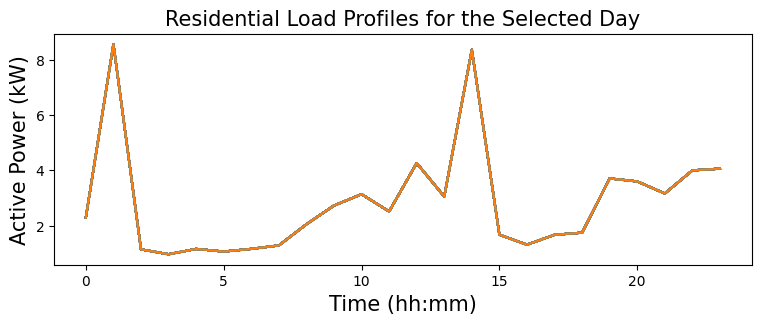

In [559]:
x=[i for i in range(24)]
l=[]
for i in range(24):
      l.append("%s:00"%i)
      l.append(" ")

fig=plt.figure(figsize=(9,3))
selected_day=45                     #here is where you can change the selected day
for row in Load_time_series[:,selected_day,:]:
   plt.plot(row, label = 'load profiles')
   plt.xlabel("Time (hh:mm)", fontsize = 15)
   plt.xticks(fontsize = 10)
  #  plt.xticks(x,l, fontsize=10, rotation=60)
   plt.ylabel('Active Power (kW)', fontsize = 15)
   plt.yticks(fontsize = 10)
   plt.title('Residential Load Profiles for the Selected Day', fontsize = 15)

#### Initiate defs and other variables

In [560]:
def Initiate_variable(customers):
    kW_monitors = np.zeros((customers,24))
    kvar_monitors = np.zeros((customers,24))
    voltages_monitors = np.zeros((customers,24))
    df_kw = pd.DataFrame()
    df_kvar = pd.DataFrame()
    df_volt = pd.DataFrame()
    load_profiles_all = []
    return  (kW_monitors, kvar_monitors, voltages_monitors, df_kw, df_kvar, df_volt, load_profiles_all)

In [561]:
def Monitors_data(itime,Loadname):
    for icust, cust in enumerate(Loadname):
            DSSCircuit.SetActiveElement('load.%s' %(cust))
            kW_monitors[icust, itime] = DSSCircuit.ActiveElement.Powers[0]
            kvar_monitors[icust,itime]= DSSCircuit.ActiveElement.Powers[1]
            bus_name = DSSCircuit.ActiveElement.Properties('bus1').Val
            DSSCircuit.SetActiveBus(bus_name)
            voltages_monitors[icust, itime] = DSSCircuit.ActiveBus.puVmagAngle[0]

#### Solve

In [562]:
Loadname = DSSCircuit.Loads.AllNames
customers = len(Loadname)
print(Loadname)

['load_bus4_dev0', 'load_bus4_dev1', 'load_bus4_dev2', 'load_bus65_dev3', 'load_bus65_dev4', 'load_bus65_dev5', 'load_bus64_dev6', 'load_bus64_dev7', 'load_bus64_dev8', 'load_bus65_dev9', 'load_bus66_dev10', 'load_bus66_dev11', 'load_bus10_dev12', 'load_bus13_dev13', 'load_bus16_dev14', 'load_bus18_dev15', 'load_bus18_dev16', 'load_bus20_dev17', 'load_bus22_dev18', 'load_bus22_dev19', 'load_bus30_dev20', 'load_bus33_dev21', 'load_bus39_dev22', 'load_bus42_dev23', 'load_bus44_dev24', 'load_bus47_dev25', 'load_bus49_dev26', 'load_bus51_dev27', 'load_bus55_dev28', 'load_bus55_dev29', 'load_bus61_dev30', 'load_bus63_dev31', 'load_bus63_dev32', 'load_bus65_dev33', 'load_bus65_dev34', 'load_bus67_dev35', 'load_bus67_dev36', 'load_bus69_dev37', 'load_bus69_dev38', 'load_bus71_dev39', 'load_bus71_dev40', 'load_bus71_dev41', 'load_bus74_dev42', 'load_bus74_dev43', 'load_bus52_dev44', 'load_bus52_dev45', 'load_bus59_dev46', 'load_bus59_dev47', 'load_bus13_dev48', 'load_bus10_dev49', 'load_bus75_

In [567]:
#Powerflow_simulation for 1 day

(kW_monitors, kvar_monitors, voltages_monitors, df_kw, df_kvar, df_volt, load_profiles_all) = Initiate_variable(customers)

for load_index, load_name in enumerate(Loadname):
  load_profile = Load_time_series[load_index, 1, :]
  reactive_load_profile = load_profile * 0
  # reactive_load_profile = (load_profile * math.tan(math.acos(0.95)))

  DSSCircuit.LoadShapes.New('customer_profile_%s' %(load_index))
  DSSCircuit.LoadShapes.Npts = 24
  DSSCircuit.LoadShapes.MinInterval = 60
  DSSCircuit.LoadShapes.UseActual = 1
  DSSCircuit.LoadShapes.Name = 'customer_profile_%s' %(load_index)

  DSSCircuit.LoadShapes.Pmult = load_profile.tolist()
  DSSCircuit.LoadShapes.Qmult = reactive_load_profile.tolist()
  DSSCircuit.SetActiveElement('load.%s'%(load_name))
  DSSCircuit.ActiveElement.Properties('daily').Val = str('customer_profile_%s' %(load_index))

DSSText.Command = 'Reset'
DSSText.Command = 'Set Mode=daily number=1 stepsize=60m'
voltages_monitors = np.zeros((customers,24))
for itime in range(24):
      DSSSolution.Solve()
      Monitors_data(itime,Loadname)
if DSSSolution.Converged:
  print('Message: The Solution Converged Successfully\n')
else:
  print("Message: The Solution Did Not Converge\n")

# print(kW_monitors)
# print(kvar_monitors)
print(voltages_monitors)
# print(voltages_monitors.shape)
# print(voltages_monitors.dtype)



Message: The Solution Converged Successfully

[[2.44800522e-01 5.95354262e+01 3.36098808e-01 ... 2.52232302e-01
  1.93424852e-01 2.06138968e-01]
 [2.44800522e-01 5.95354262e+01 3.36098808e-01 ... 2.52232302e-01
  1.93424852e-01 2.06138968e-01]
 [2.44800522e-01 5.95354262e+01 3.36098808e-01 ... 2.52232302e-01
  1.93424852e-01 2.06138968e-01]
 ...
 [1.70254886e-02 1.17537216e+02 4.80605415e-02 ... 1.83342342e-02
  9.68038419e-03 1.12317474e-02]
 [1.45620940e-03 1.66914716e+02 6.20148429e-02 ... 1.73604053e-03
  3.78875037e-04 5.25666600e-04]
 [1.45620940e-03 1.66914716e+02 6.20148429e-02 ... 1.73604053e-03
  3.78875037e-04 5.25666600e-04]]


In [564]:
# from dss import plot
# plot.enable()
# # dss.Plotting.enable()
# DSSText.Command = 'plot circuit'

In [565]:
#Powerflow simulation for all days

# voltage_outcomes = np.zeros((1000,52,24))
# for day in range(10):
#   (kW_monitors, kvar_monitors, voltages_monitors, df_kw, df_kvar, df_volt, load_profiles_all) = Initiate_variable(customers)

#   for load_index, load_name in enumerate(Loadname):
#     load_profile = Load_time_series[load_index, 0, :]

#     DSSCircuit.LoadShapes.New('customer_profile_%s' %(load_name))
#     DSSCircuit.LoadShapes.Npts = 24
#     DSSCircuit.LoadShapes.MinInterval = 60
#     DSSCircuit.LoadShapes.UseActual = 1
#     DSSCircuit.LoadShapes.Name = 'customer_profile_%s' %(load_name)
#     DSSCircuit.LoadShapes.Pmult = load_profile.tolist()
#     DSSCircuit.SetActiveElement('load.%s'%(load_name))
#     DSSCircuit.ActiveElement.Properties('daily').Val = str('customer_profile_%s' %(load_name))

#   DSSText.Command = 'Reset'
#   DSSText.Command = 'Set Mode=daily  number=1 stepsize=60m'
#   for itime in range(24):
#         DSSSolution.Solve()
#         Monitors_data(itime)
#   voltage_outcomes[day] = voltages_monitors

# voltage_outcomes = np.transpose(voltage_outcomes, (0, 2, 1))
# print(voltage_outcomes)
